# Introduction to Convolutional Neural Networks for Signal Classification
The content of this tutorial was developed by Team 3 as part of an engineering project management class. It draws upon various research sources including PyTorch and Jovian. Feel free to explore these sources for further information on specific topics. Additionally, we have provided links below to delve deeper into particular sections.

## Jovian Sources:

**Note:** To run these codes, when you open the link there is a run button in the top right corner, click on it. Then, click on "run on colab." After, click on "run with out authorization." Then, you can learn and edit how you see fit.
1. [PyTorch Basics: Tensors & Gradients](https://jovian.com/outlink?url=https%3A%2F%2Fjovian.ai%2Faakashns%2F01-pytorch-basics)
2. [Gradient Descent & Linear Regression](https://jovian.com/outlink?url=https%3A%2F%2Fjovian.ai%2Faakashns%2F02-linear-regression)
3. [Working with Images & Logistic Regression](https://jovian.com/outlink?url=https%3A%2F%2Fjovian.ai%2Faakashns%2F03-logistic-regression)
4. [Training Deep Neural Networks on a GPU](https://jovian.com/outlink?url=https%3A%2F%2Fjovian.ai%2Faakashns%2F04-feedforward-nn)
5. [Image Classification using Convolutional Neural Networks](https://jovian.com/outlink?url=https%3A%2F%2Fjovian.ai%2Faakashns%2F05-cifar10-cnn)
6. [Data Augmentation, Regularization and ResNets](https://jovian.com/outlink?url=https%3A%2F%2Fjovian.ai%2Faakashns%2F05b-cifar10-resnet)
7. [Generating Images using Generative Adversarial Networks](https://jovian.com/outlink?url=https%3A%2F%2Fjovian.ai%2Faakashns%2F06b-anime-dcgan%2F)

## Pytorch Sources:

Pytorch Website: https://pytorch.org/tutorials/

Pytorch Videos by CODEMY: https://www.youtube.com/watch?v=kY14KfZQ1TI&list=PLCC34OHNcOtpcgR9LEYSdi9r7XIbpkpK1



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#intializations
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import csv
import time
import numpy as np
from scipy.signal import resample_poly

# Datagen Imports
import os
import pandas as pd
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split


# Create Custom Radio Frequency Dataset

This code defines a custom dataset class in PyTorch, RFdataset, which loads dataset and label sets from files. This is important because it simplifies data loading for machine learning tasks, enhances code modularity, and integrates seamlessly with PyTorch's data loading utilities, enabling efficient handling of large datasets and compatibility with various workflows.


---


### **HOW TO SET UP THE DATA (IMPORTANT!!!)**
1. Look on the Left side and click the file icon
2. Make sure you Colab has access to your file by hitting the drive icon
3. click on the drive folder and find the downloaded "Tutorial Data Info" folder
4. Once found left find 2 datasets: "tutorial_5signal_dataset_20000examples" and "tutorial_5signal_labelset_20000examples"
5. Next, click on the data set file you want to get the path and replace what is in the dataset below.
6. Additionally, there is a comment that says "CHANGE DATASET HERE"

In [ ]:
class RFdataset(Dataset):
    def __init__(self, dataset, labelset):
        self.dataset = torch.load(dataset)
        self.label = torch.load(labelset).type(torch.LongTensor)
        self.num_samples = self.dataset.shape[0]
    def __getitem__(self, index):
        return self.dataset[index], self.label[index]
    def __len__(self):
        return self.num_samples

# Download Dataset from dataset and label set files through using the class RFdataset
# CHANGE DATASET HERE
dataset = RFdataset('/content/drive/MyDrive/Colab Notebooks/Tutorial Data Info/tutorial_5signal_dataset_20000examples.pt', '/content/drive/MyDrive/Colab Notebooks/Tutorial Data Info/tutorial_5signal_labelset_20000examples.pt')

# Normalization

In this loop, each iteration extracts a sample **'x'** from the dataset, where **'x'** consists of a radio frequency (RF) input and its corresponding label. The RF input **'rf'** is processed to calculate its mean and variance using PyTorch functions. Subsequently, the RF input is normalized using these statistics, which helps stabilize training and improve model performance. Finally, the normalized RF input and its label are reassigned to **'data_normalized'** and **'labels'**, respectively, for further processing or model training. This loop efficiently prepares the dataset by normalizing RF inputs, which is crucial for enhancing model convergence and generalization in machine learning tasks.

In [ ]:
for x in dataset:
    rf, lables = x
    data_mean = torch.mean(rf)
    data_var = torch.var(rf)
    data_normalized = (rf - data_mean)/(torch.sqrt(data_var))
    data_normalized, labels = x

# Split Orginial Dataset Into Train, Validation, and Test Sets
While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set or test set, we can set aside two small portions (4000 signals for validation and 1000 for the test set) of the training set to be used as the validation set and test set. We will use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we will also set a seed for the random number generator.

In [ ]:
# POSSIBLY COULD GET RID OF THIS???
#Load dataset into DataLoader for model
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=0)

#random seed ensures reproducability of random outcomes
random_seed = 67
torch.manual_seed(random_seed)

#This is purely used to reduce the amount of examples used in training. THIS IS NOT NECESSARY TO USE.
'''
train1_size = 460000
train_size = len(dataset) - train1_size
train_ds_before_train1, val_ds= random_split(dataset, [train_size, train1_size])
'''

val_size = 4000
train_size = len(dataset) - val_size
train_ds_before_test, val_ds= random_split(dataset, [train_size, val_size])


test_size = 1000
train_size = len(train_ds_before_test) - test_size
train_ds, test_ds = random_split(train_ds_before_test, [train_size, test_size])
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

# set shuffle to true for more randomization within batches.
batch_size = 200
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=0, pin_memory=True)

15000
4000
1000


# Creating The Model and Class to Support The Model
The **'Conv2d'** layer transforms a 3-channel image/signal to a 16-channel *feature map*, and the **'MaxPool2d'** layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 4 for each images/signals.

**Note:** Feel free to customize your network according to your preferences. In this specific model, pooling was omitted as it didn't align with the project requirements, as per the creator's discretion. The creator of this tutorial model is Zymmorrah Myers. For any inquiries regarding the model, you can contact her at mzymmorrah18@vt.edu.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

This code defines a base class **'ImageClassificationBase'** for image classification tasks in PyTorch. It contains methods for training (**'training_step'**), validation (**'validation_step'** and **'validation_epoch_end'**), and tracking performance (**'epoch_end'**). In **'training_step'**, it computes the loss using CrossEntropyLoss between predicted and actual labels. **'validation_step'** computes both loss and accuracy for validation data, and **'validation_epoch_end'** aggregates these metrics for the entire validation dataset. **'epoch_end'** prints the training and validation losses, validation accuracy, and the time taken for each epoch. Additionally, there's a helper function **'accuracy'** to calculate the accuracy of model predictions. This base class streamlines the process of training and evaluating image classification models by providing standardized methods for common tasks.


In [ ]:
#Create a Model Class that inherits nn.Module
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = model(images)                # Generate predictions
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = model(images)         # Generate predictions
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)[0]          # Calculate accuracy
        preds = accuracy(out, labels)[1]
        labels = accuracy(out, labels)[2]
        return {'val_loss': loss.detach(), 'val_acc': acc}, preds, labels, acc

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result, start_time):
        end_time = time.time()
        epoch_time = end_time - start_time
        minutes, seconds = divmod(epoch_time, 60)
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc'])+ f" took {int(minutes)} minutes and {seconds:.2f} seconds ")

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds, labels

# Defining the Model (Convolutional Neural Network)

For this tutorial, we will use a convolutional neural network, using the **'nn.Conv2d'** class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">



**About The Code:** This code defines a neural network model called RFCnnModel for image classification tasks. It consists of three convolutional layers (conv1, conv2, and conv3) followed by fully connected layers (fc1, fc2, fc3, and fc4). The input image has a single channel, and each convolutional layer applies a specific number of filters with certain kernel sizes and padding. The output of the convolutional layers is flattened and passed through the fully connected layers. The ReLU activation function is applied after each layer, except for the final layer. The model is instantiated at the end using the RFCnnModel class.

In [ ]:
#Neural Network Model for the code
class RFCnnModel(ImageClassificationBase):
    def __init__(self):
        super(RFCnnModel, self).__init__()
        #Change and maniputlate how you see fit
        self.conv1 = nn.Conv2d(1, 16, (2, 10), padding=2) #input = 1 becuase we have 1 channel
        self.conv2 = nn.Conv2d(16, 32, (2, 10), stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, (2, 10), stride=2, padding=2)
        self.fc1 = nn.Linear(64256, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 11)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = RFCnnModel()

# Get and Load Device

This code provides utility functions and a wrapper class to handle moving data and models to a specified device, such as a GPU or CPU. The **'get_default_device'** function determines whether a GPU is available; if so, it returns the GPU device, otherwise, it returns the CPU device. The **'to_device'** function moves tensors to the specified device, recursively handling lists or tuples of tensors.

The **'DeviceDataLoader'** class is a wrapper around a PyTorch DataLoader, ensuring that data batches are transferred to the specified device. It overrides the **'__iter__'** method to yield batches of data after moving them to the device.

Finally, the code initializes the device, wraps the training, validation, and test data loaders with **'DeviceDataLoader'** to move data batches to the device, and moves the model to the device using the **'to_device'** function. This ensures that both data and model computations are performed on the chosen device, optimizing performance and resource utilization.

**Note:** To utilize a GPU, navigate to "Runtime" in the top bar and select "Change runtime type." Then, choose "T4 GPU." Note that GPU usage is limited per day, so remember to turn it off when not in use to conserve resources.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = to_device(model, device)

# Save Checkpoint
This code defines functions for saving and loading model checkpoints. The **'save_checkpoint'** function saves the model state and optimizer parameters to a file named "my_checkpoint.pth.tar". The **'load_checkpoint'** function loads the saved checkpoint if it exists, restoring the model and optimizer states. If the file doesn't exist, it creates an empty checkpoint file named **"checkpoint.pth.tar"**.


---



**Why do we need this if we are saving the model at the end?**
It is important because if you experience a crash or you did not run enough epochs this will allow you to start where you left off.


---



**Note:**`load_model`is set to ***true*** to load all data from the last executed epoch. Remember, if you're conducting different tests and need to save different checkpoint sets change the `filename`, or to prevent overwritting in general set `load_model` to ***false***.

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
            print("=> Saving checkpoint")
            torch.save(state, filename)

load_model = True
def load_checkpoint(checkpoint):
    print("=> Loading Chekpoint")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
if load_model:
    if os.path.exists("my_checkpoint.pth.tar"):
      load_checkpoint(torch.load("my_checkpoint.pth.tar"))
    else:
      open("checkpoint.pth.tar", 'w')

=> Loading Chekpoint


# Training The Model

The steps that were taken to train this specific model (this can be done differently if you so choose):
1. Set the learning rate (**'lr'**) to 0.01 and the optimizer function (**'opt_func'**) to Stochastic Gradient Descent (**'torch.optim.SGD'**).
2. Define an evaluation function evaluate and a training function fit.
3. Initialize an empty history list to store training and validation metrics.
4. Set up a loop to iterate over the specified number of epochs.
5. During each epoch:

  *   Set the model to training mode (**'model.train()'**).
  *   Iterate over the training data batches, compute the loss, perform backpropagation, and update the model parameters.
  *   Check if the current epoch is a multiple of 3; if so, save a checkpoint of the model's state and optimizer's state.
  *   Evaluate the model on the validation data, compute metrics, and record the results.
  *   Track training and validation losses and print the progress.
  *   Implement early stopping by monitoring the validation loss (to prevent overfitting); if it exceeds a certain threshold for two consecutive epochs, stop training and return the history, predicted labels, and true labels.
6. Run the training process for a specified number of epochs (**'num_epochs'**).

In [ ]:
lr = 0.01
opt_func=torch.optim.SGD
optimizer = opt_func(model.parameters(), lr)
with torch.no_grad():
    def evaluate(model, val_loader):
        model.eval()
        outputs = [model.validation_step(batch)[0] for batch in val_loader]
        preds = [model.validation_step(batch)[1] for batch in val_loader]
        labels = [model.validation_step(batch)[2] for batch in val_loader]
        acc = [model.validation_step(batch)[3] for batch in val_loader]
        acc = [torch.mean(torch.stack(acc))]
        return model.validation_epoch_end(outputs), preds, labels, acc
    def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
        history = []
        preds = []
        labels = []
        torch.autograd.set_detect_anomaly(True)
        optimizer = opt_func(model.parameters(), lr)
        num = 0
        val_loss_hist = []
        for epoch in range(epochs):
            start_time = time.time()
            # Training Phase
            model.train()
            train_losses = []
            if epoch % 5 == 0:
                checkpoint = {'state_dict' : model.state_dict(), 'optimizer': optimizer.state_dict()}
                save_checkpoint(checkpoint)
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # Validation phase
            result = evaluate(model, val_loader)[0]
            preds = []
            labels = []
            preds += evaluate(model, val_loader)[1]
            labels += evaluate(model, val_loader)[2]
            delta = 0.05
            result['train_loss'] = torch.stack(train_losses).mean().item()
            model.epoch_end(epoch, result, start_time)
            if epoch !=0:
                val_loss_hist += [history[epoch-1]['val_loss']]
            if epoch != 0 and result['val_loss'] <= min(val_loss_hist):
                num = 0
            if epoch != 0 and result['val_loss'] > (min(val_loss_hist) + delta):
                num += 1
                if num == 2:
                    history.pop(epoch-1)
                    history.pop(epoch-2)
                    return history, preds, labels
            history.append(result)
        return history, preds, labels


#number of epoch you want to run
num_epochs = 10

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

=> Saving checkpoint
Epoch [0], train_loss: 1.0835, val_loss: 0.8498, val_acc: 0.6247 took 0 minutes and 17.68 seconds 
Epoch [1], train_loss: 0.7510, val_loss: 0.6028, val_acc: 0.6800 took 0 minutes and 13.11 seconds 
Epoch [2], train_loss: 0.5428, val_loss: 0.4353, val_acc: 0.7887 took 0 minutes and 12.55 seconds 
Epoch [3], train_loss: 0.4034, val_loss: 0.3609, val_acc: 0.7837 took 0 minutes and 12.51 seconds 
Epoch [4], train_loss: 0.3165, val_loss: 0.2385, val_acc: 0.8958 took 0 minutes and 12.54 seconds 
=> Saving checkpoint
Epoch [5], train_loss: 0.1228, val_loss: 0.0682, val_acc: 0.9887 took 0 minutes and 13.70 seconds 
Epoch [6], train_loss: 0.0506, val_loss: 0.0375, val_acc: 0.9933 took 0 minutes and 12.56 seconds 
Epoch [7], train_loss: 0.0283, val_loss: 0.0237, val_acc: 0.9965 took 0 minutes and 12.72 seconds 
Epoch [8], train_loss: 0.0179, val_loss: 0.0158, val_acc: 0.9975 took 0 minutes and 12.94 seconds 
Epoch [9], train_loss: 0.0137, val_loss: 0.0124, val_acc: 0.9985 to

# Plotting

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patterns that are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase



## Accuracy Plot:
An accuracy plot is essential to visualize how well the model performs over epochs. It helps in assessing the convergence of the model during training and evaluating its performance on the validation set.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history[0]]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

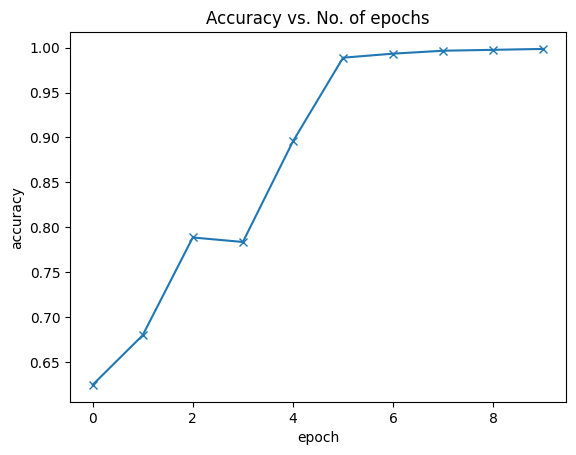

In [ ]:
plot_accuracies(history)

## Training and Validation Loss Plot:

The training and validation loss plot is crucial for monitoring the training process. It illustrates the progression of the model's loss function over epochs for both training and validation data. A decreasing trend in loss indicates that the model is learning and improving its performance. Discrepancies between training and validation loss can highlight issues like overfitting or underfitting.


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history[0]]
    val_losses = [x['val_loss'] for x in history[0]]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

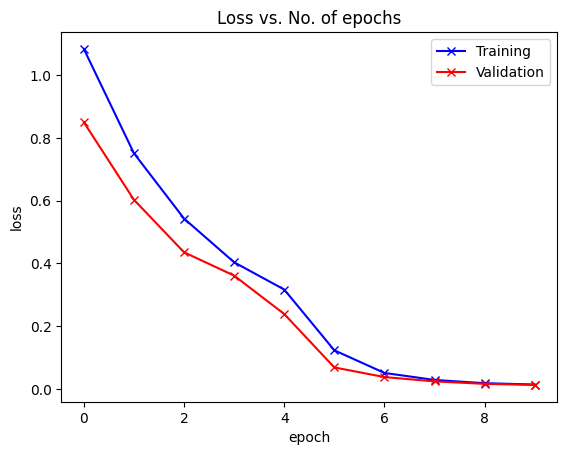

In [ ]:
plot_losses(history)

## PCA Plot:

Principal Component Analysis (PCA) plots help visualize the high-dimensional feature space in a lower-dimensional space. It is useful for understanding the distribution and separability of data points, especially in this case where the original feature space is complex or has many dimensions. PCA plots reveal patterns, clusters, or anomalies in the data, aiding in feature selection, dimensionality reduction, and understanding the data structure.

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def plot_pca():
    model.fc3.register_forward_hook(get_activation('fc3'))
    activations = torch.empty(0, 128)
    labels = torch.empty(0)
    for batch in test_dl:
        output = model.validation_step(batch)[0]
        model_labels = model.validation_step(batch)[2]
        activations = torch.cat((activations, activation['fc3'].cpu()), 0)
        labels = torch.cat((labels, model_labels.cpu()), 0)

    labels = labels.type('torch.IntTensor')

    from sklearn.decomposition import PCA

    target_names = ['2-ASK', 'BPSK','Constant Tone','P-FMCW','N-FMCW']
    pca = PCA(n_components=2)
    X_r = pca.fit(activations).transform(activations)
    colors = ["navy", "turquoise", "darkorange", "pink", "brown"]


    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
        plt.scatter(
            # I want to eventually have a scaling alogirthm here for the SNRs
            X_r[labels==i, 0], X_r[labels==i, 1], color=color, label=target_name
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("PCA of RF dataset")
    plt.figure()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


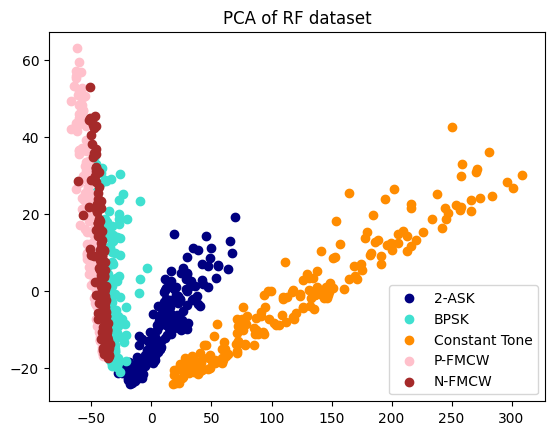

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_pca()

## Confusion Matrices Plot:

Confusion matrices provide a comprehensive view of the model's performance across different signals. They display the number of correct and incorrect predictions for each signal, allowing for the assessment of the model's accuracy, precision, recall, and F1-score. Confusion matrices are particularly useful for multiclass or multisignal classification tasks, where they help identify misclassifications and assess the model's overall performance on individual signals. They provide insights into the model's strengths and weaknesses, aiding in fine-tuning and improvement strategies.



In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion(history):

    word_map = { 0: '2-ASK', 1: 'BPSK', 2: 'Cnst T', 3: 'P-FMCW', 4: 'N-FMCW'}
    label = ['2-ASK', 'BPSK', 'Cnst T', 'P-FMCW', 'N-FMCW']

    preds = [x for x in history[1]]
    labels_list = [x for x in history[2]]
    preds = torch.stack(preds).cpu()
    labels_list = torch.stack(labels_list).cpu()
    np_preds = np.zeros(preds.shape[1])
    np_labels = np.zeros(preds.shape[1])
    for i in range(preds.shape[1]):
        np_preds[i] = preds[0][i]
        np_labels[i] = labels_list[0][i]
    np_preds_results = np_preds
    np_labels_results = np_labels

    np_preds_results = [word_map[num] for num in np_preds_results]
    np_labels_results = [word_map[num] for num in np_labels_results]

    # Create and display the confusion matrix
    cm = confusion_matrix(np_labels_results, np_preds_results, labels=label, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
    disp.plot(cmap='Blues', values_format='.2f')
    plt.figure()

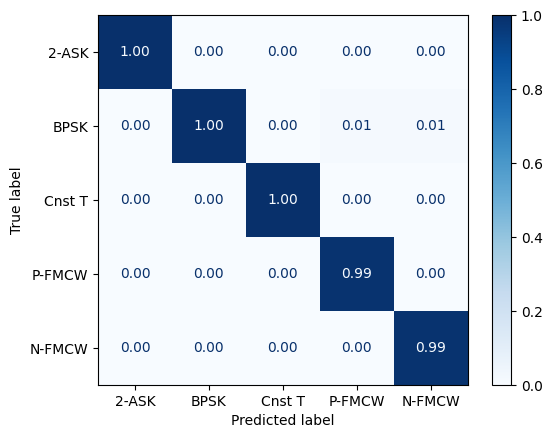

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_confusion(history)

## SNR Plot:

An SNR (Signal-to-Noise Ratio) plot is crucial for evaluating the performance of a neural network across different levels of noise. By analyzing the model's performance under varying SNR conditions, this plot provides insights into its robustness and generalization capabilities in real-world scenarios where data may be corrupted by noise. It helps identify SNR thresholds at which performance degradation occurs, guiding decisions on noise reduction strategies and model preprocessing. Additionally, the SNR plot aids in optimizing model architecture and training methodologies to enhance resilience to noise. Furthermore, it serves as a validation tool to ensure the model's reliability and applicability across diverse noise conditions, informing decisions on model deployment and suitability for noise-affected datasets.



In [ ]:
# Download SNR Datasets
snr_datasets = {}  # Dictionary to store all datasets

# Iterate over SNR values from 5 to 20
for snr in range(5, 21):
    # Construct the file paths
    dataset_path = f'/content/drive/MyDrive/Colab Notebooks/Tutorial Data Info/tutorial_{snr}SNR_dataset_500examples.pt'
    labelset_path = f'/content/drive/MyDrive/Colab Notebooks/Tutorial Data Info/tutorial_{snr}SNR_labelset_500examples.pt'

    # Create RFdataset object and store it in the dictionary
    snr_datasets[f'test{snr}_ds'] = RFdataset(dataset_path, labelset_path)

# Normalize data like before
for snr in range(5, 21):
    dataset_snr = snr_datasets[f'test{snr}_ds']
    normalized_data = []
    for rf, labels in dataset_snr:
        data_mean = torch.mean(rf)
        data_var = torch.var(rf)
        data_normalized = (rf - data_mean) / (torch.sqrt(data_var))
        normalized_data.append((data_normalized, labels))
    # Update dataset with normalized data
    snr_datasets[f'test{snr}_ds'] = normalized_data

# Put in DataLoader and GPU device
test_loaders = {}
for snr in range(5, 21):
    loader_name = f'snr{snr}_test_loader'
    test_loaders[loader_name] = DataLoader(snr_datasets[f'test{snr}_ds'], batch_size=100, num_workers=0, pin_memory=True)
    test_loaders[loader_name] = DeviceDataLoader(test_loaders[loader_name], device)

def plot_snrs():
    snr_acc = []
    snrs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    # Assuming evaluate function returns accuracy values for each SNR
    for snr in snrs:
        snr_acc += evaluate(model, test_loaders[f"snr{snr}_test_loader"])[3]

    plt.plot(snrs, snr_acc, '-x')
    plt.xlabel('SNR (db)')
    plt.ylabel('Average Probability of Correct Classification')
    plt.show()

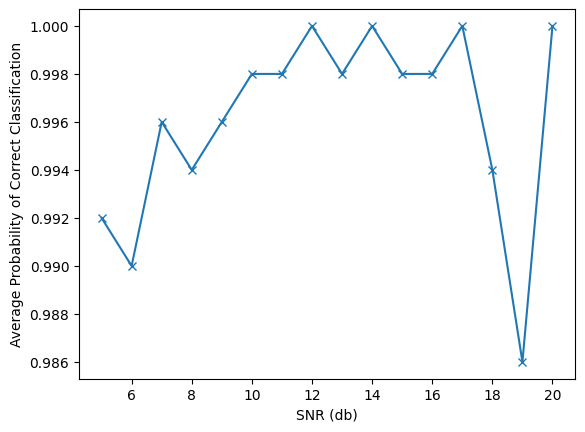

In [ ]:
plot_snrs()

# Extract Features and Save the Model

In tutorial three, leveraging features extracted from various neural network models is crucial for preparing data for clustering algorithms. This transformation of high-dimensional data into meaningful feature vectors enables efficient partitioning based on similarity, facilitating tasks like customer segmentation or anomaly detection for effective data exploration. The objective is to combine these features with others from different networks to enhance performance.

In tutorial three, you'll start by using your own features in a clustering algorithm setup to grasp the process. Later, you'll progress to implementing your own neural network, gaining access to each team's models to perform clustering algorithms on both your features and those from another team. These tutorials just provide you with a solid base.

As for the saved model, saving your model is crucial for preserving its learned parameters, architecture, and state. This ensures that you can easily reload and reuse the model for inference, deployment, or further training without having to retrain it from scratch, thereby saving time and computational resources.


---

### TO DO FOR TUTORIAL 3:

1. Download the activations from the Colab file icon in the left hand tool bar to use in the next tutorial.
2. After downloading, add the activations to the same folder you have the tutorials in.

In [ ]:
def save_features():
    model.fc1.register_forward_hook(get_activation('fc1'))
    print('test_dl length:',len(test_dl))
    activations1 = torch.empty(0, 1024)
    labels1 = torch.empty(0)
    for batch in test_dl:
        output = model.validation_step(batch)[0]
        model_labels = model.validation_step(batch)[2]
        activations1 = torch.cat((activations1, activation['fc1'].cpu()), 0)
        labels1 = torch.cat((labels1, model_labels.cpu()), 0)
    print('labels1:', labels.shape)
    print("activation1:", activations1.shape)

    model.fc2.register_forward_hook(get_activation('fc2'))
    print('test_dl length:',len(test_dl))
    activations2 = torch.empty(0, 512)
    labels2 = torch.empty(0)
    for batch in test_dl:
        output = model.validation_step(batch)[0]
        model_labels = model.validation_step(batch)[2]
        activations2 = torch.cat((activations2, activation['fc2'].cpu()), 0)
        labels2 = torch.cat((labels2, model_labels.cpu()), 0)
    print('labels:', labels2.shape)
    print("activation2:", activations2.shape)

    model.fc3.register_forward_hook(get_activation('fc3'))
    print('test_dl length:',len(test_dl))
    activations3 = torch.empty(0, 128)
    labels3 = torch.empty(0)
    for batch in test_dl:
        output = model.validation_step(batch)[0]
        model_labels = model.validation_step(batch)[2]
        activations3 = torch.cat((activations3, activation['fc3'].cpu()), 0)
        labels3 = torch.cat((labels3, model_labels.cpu()), 0)
    print('labels3:', labels3.shape)
    print("activation3:", activations3.shape)

    #creates feature paths that can be manipulated using Random Forest or XGB
    #Random Forest worked best for me
    torch.save({'activations1': activations1, 'labels1': labels1}, 'activations1.pth')
    torch.save({'activations2': activations2, 'labels2': labels2}, 'activations2.pth')
    torch.save({'activations3': activations3, 'labels3': labels3}, 'activations3.pth')


In [ ]:
save_features()

test_dl length: 3
labels1: torch.Size([])
activation1: torch.Size([1000, 1024])
test_dl length: 3
labels: torch.Size([1000])
activation2: torch.Size([1000, 512])
test_dl length: 3
labels3: torch.Size([1000])
activation3: torch.Size([1000, 128])


In [ ]:
import torch
import torchvision.models as models

# Save the entire model
open("entire_model.pth", 'w')
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
   'optimizer_state_dict': optimizer.state_dict(),
   'history': history,
}, 'entire_model.pth')